# Stable Diffusion 2.1

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.86it/s]


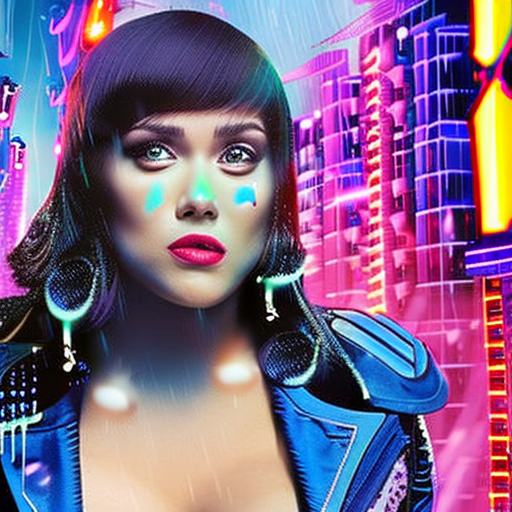

In [8]:
import logging
import torch
import random
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

# Static seed for reproducibility or turn on randomization
RANDOM_SEED = 42
RANDOMIZE_SEED = False

# Check if we should use a static seed, if not randomize it
if RANDOMIZE_SEED:
    RANDOM_SEED = random.randint(0, 1000000000)
    print(f"Using seed: {RANDOM_SEED}")

# User-definable parameters with defaults
parameters = {
    "prompt": "Hyperrealistic. A beautiful cyberpunk woman in a futuristic city, surrounded by neon lights and rain. The background features towering skyscrapers with vibrant neon signs, futuristic vehicles, and wet streets reflecting the city lights. The atmosphere is moody with a dark, rainy night, creating a cinematic, sci-fi look.",
    "negative_prompt": "Low quality, blurry, unrealistic, poorly lit, lack of detail, no futuristic elements, unattractive, low-resolution, no rain, no neon lights, no cyberpunk elements.",
    "num_inference_steps": 50,  # Number of denoising steps
    "guidance_scale": 14.0,  # Adherence to prompt
    "width": 512,  # Image width
    "height": 512,  # Image height
    "seed": RANDOM_SEED,  # Seed for reproducibility
    "device": None,  # Device for computation
    "use_amp": True,  # Automatic mixed precision
    "cpu_only": False,  # Force CPU usage if True
}

def get_device(device="cpu"):
    """
    This will check for an Intel XPU device and return it if available, otherwise it will return cpu.

    Returns the torch device to use.
    """
    if parameters['cpu_only'] == False:
        #device = "xpu" if torch.xpu.is_available() else "cpu"
        if torch.xpu.is_available():
            device = "xpu"
        elif torch.cuda.is_available():
            device = "cuda"
        else:
            device = "cpu"

        logging.info(f"Using device: {device}")
        return device
    else:
        logging.info("Using CPU only")
        return "cpu"

parameters["device"] = get_device()

# Disable gradients since we are not training
torch.set_grad_enabled(False)

# Configure random seed
generator = torch.manual_seed(parameters["seed"])

# Load the pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1", 
    torch_dtype=torch.float32 if parameters["device"] == "cpu" else torch.float16
)

# Load and set the DPM++ 2M scheduler
pipe.scheduler = DPMSolverMultistepScheduler.from_pretrained(
    "stabilityai/stable-diffusion-2-1", 
    subfolder="scheduler"
)

# Move pipeline to the desired device
pipe = pipe.to(parameters["device"])

# Generate the image
with torch.autocast(parameters["device"]) if parameters["use_amp"] else torch.no_grad():
    image = pipe(
        prompt=parameters["prompt"],
        negative_prompt=parameters["negative_prompt"],
        num_inference_steps=parameters["num_inference_steps"],
        guidance_scale=parameters["guidance_scale"],
        height=parameters["height"],
        width=parameters["width"],
        generator=generator,
    ).images[0]

# Display the image
image